# Generating Pixels One by One: Your First Autoregressive Image Generation Model

Welcome, I am glad you are here!

I'm [Tuna](https://tunahansalih.github.io). My world is pretty much all about image and video generation. It is what I focus on in my PhD and during my internships at places like Adobe (working on Firefly!) and Amazon AGI. For a while, I have been working with diffusion-based models, they are incredibly powerful. 

But the landscape of generative modeling is always growing, and I want to explore other types of generative models. Right now, I am diving into autoregressive models. I always find the best way to learn a topic is by trying to teach it to others. So, this blog post series is an attempt to teach myself the basics of autoregressive models, hoping you can learn something from it, too. I'll start with the basics and try to understand how these models work piece by piece.

So, if you are curious about this side of the generative AI, let's get started and see how to generate images pixel by pixel!



Alright, "Autoregressive". Let's break it down.

You have already seen "auto-regressive" models in action even if you didn't call them that. At its heart, it basically means predicting the next outcome based on all the things that came before it.

Think about how you type on your phone. When you write "the weather is ...", the keyboard will suggest completions based on the words you entered such as "sunny", "rainy", "perfect for AI research" (maybe not that last one). That is an auto-regressive model in action for language. 

Basically, predicting P(next word | all previous words) is an auto-regressive model.



torch.Size([100, 1, 28, 28])


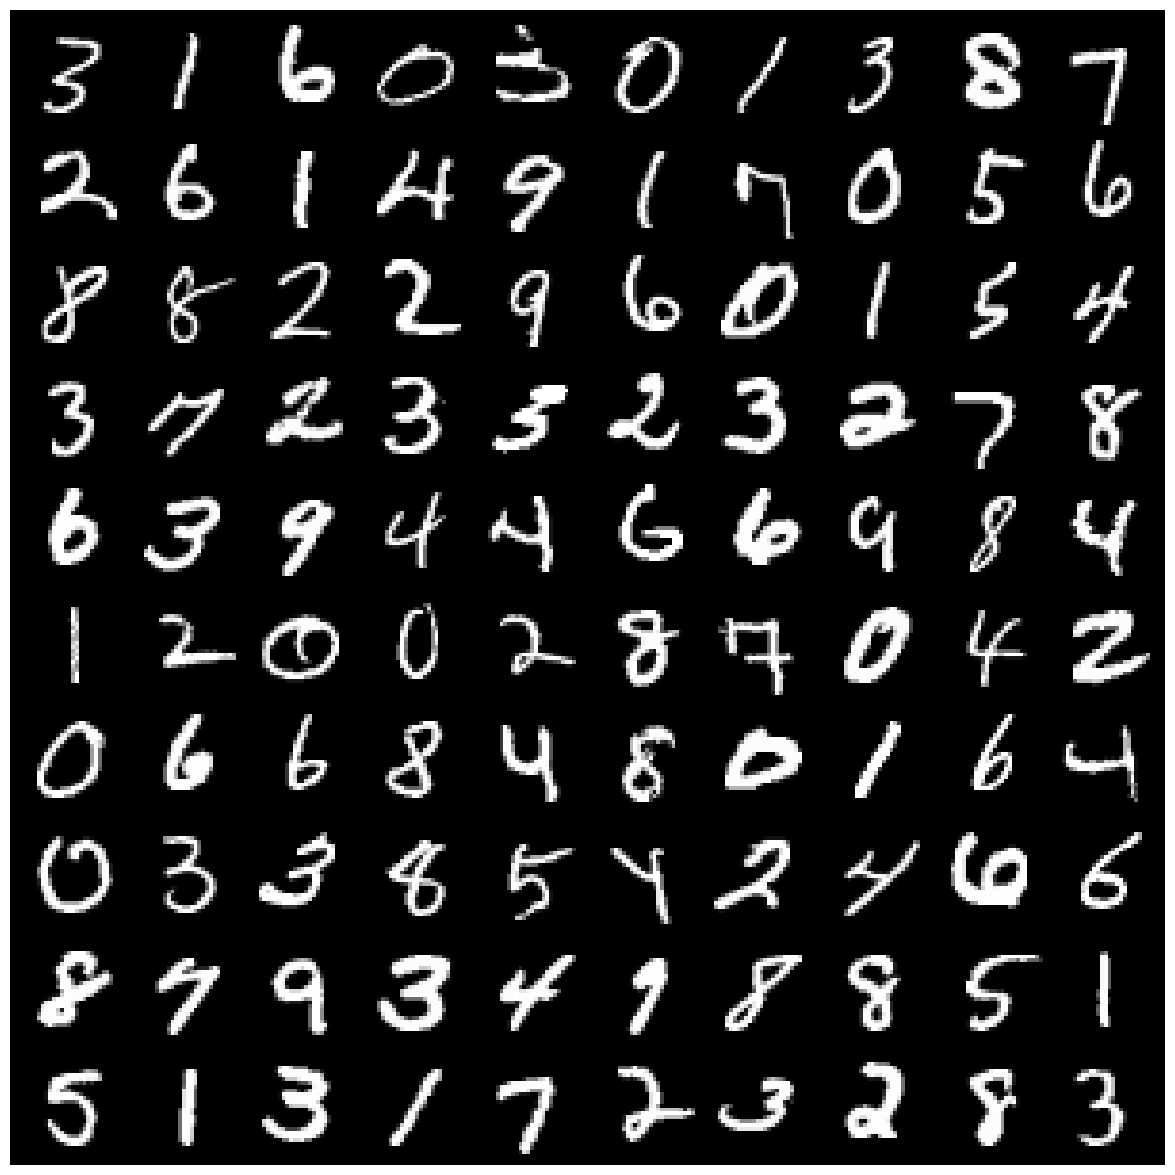

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True)
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 15))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()



In [2]:
import torch
import torchvision.transforms as transforms

# --- Hyperparameters ---
BATCH_SIZE = 16
IMG_SIZE = 28
N_PIXELS = IMG_SIZE * IMG_SIZE # 784
CONTEXT_LENGTH = 5 # Let's say we look at the last 5 elements (can be start tokens or pixels)
START_TOKEN_VALUE = -1.0 # A value distinct from our binarized pixels (0.0 or 1.0)

# --- Data Loading and Preprocessing ---
def binarize_transform(tensor_image):
    return torch.where(tensor_image > 0.5, 1.0, 0.0).float()

transform = transforms.Compose([
    transforms.ToTensor(),
    binarize_transform
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)




In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ContextualPixelPredictor(nn.Module):
    def __init__(self, input_size=CONTEXT_LENGTH, hidden_size=128, output_size=1):
        super(ContextualPixelPredictor, self).__init__()
        # Input is now a window of 'context_length' previous elements
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x is a tensor of shape [batch_size, CONTEXT_LENGTH]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Output raw logits for the next pixel
        return x

model = ContextualPixelPredictor(input_size=CONTEXT_LENGTH, hidden_size=256, output_size=1)
print(model)

ContextualPixelPredictor(
  (fc1): Linear(in_features=5, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [4]:
def create_context_target_pairs(flat_images_batch, context_length, start_token_value):
    """
    Prepares context windows and target pixels for a batch of flattened images.
    Each image in the batch will be prepended with 'context_length -1' start tokens.
    Then, for each actual pixel, its context is the 'context_length' elements
    preceding it (which can be start tokens or actual pixels).

    Args:
        flat_images_batch (Tensor): Batch of flattened images [BATCH_SIZE, N_PIXELS]
        context_length (int): The number of previous elements to use as context.
        start_token_value (float): The value for the start token.

    Returns:
        contexts (Tensor): [BATCH_SIZE * N_PIXELS, context_length]
        targets (Tensor): [BATCH_SIZE * N_PIXELS, 1]
    """
    batch_size, n_pixels = flat_images_batch.shape
    device = flat_images_batch.device

    # Create padding of start tokens
    # We need enough padding so that the first pixel has a full context window
    # Example: context_length=3. Image: [p1, p2, p3]. Padded: [S, S, p1, p2, p3]
    # Context for p1: [S, S, S_implicit_before_p1] -> no, this is not quite right.
    # Context for p1: [S, S, S] (if p1 is the target)
    # Let's define it as: to predict pixel `i`, use `padded_sequence[i : i + context_length]`
    # and target is `padded_sequence[i + context_length]` if we shift the target.

    # Simpler:
    # Padded sequence: [S, S, ..., S (context_length times), p1, p2, ..., pN]
    # To predict p1: context is [S, S, ..., S] (context_length times)
    # To predict p2: context is [S, S, ..., S, p1]
    # ...
    # To predict p_k: context is [S, ..., p_{k-1}] (window of size context_length ending at p_{k-1})
    
    all_contexts = []
    all_targets = []

    for i in range(batch_size):
        single_flat_image = flat_images_batch[i] # Shape [N_PIXELS]
        
        # Prepend (context_length - 1) start tokens to the image
        # If context_length = 1, no padding needed. If context_length=3, pad with 2 start tokens.
        num_pads = context_length -1 # if context_length is 1, this is 0.
        
        # Corrected padding logic:
        # To predict pixel p_j, the context is [x_{j-CONTEXT_LENGTH}, ..., x_{j-1}]
        # where x can be a start token or a previous pixel.
        # So, we effectively prepend CONTEXT_LENGTH start tokens to the sequence from which contexts are drawn
        # and CONTEXT_LENGTH-1 start tokens before the first target.

        # Create a sequence that includes start tokens for context building
        # [S, S, ..., S (CONTEXT_LENGTH times), p0, p1, ..., pN-1]
        padded_sequence = torch.cat([
            torch.full((context_length,), start_token_value, device=device),
            single_flat_image
        ]) # Shape: [CONTEXT_LENGTH + N_PIXELS]

        # Slide a window to create context-target pairs
        for j in range(n_pixels): # For each actual pixel we want to predict
            context = padded_sequence[j : j + context_length] # Window of size CONTEXT_LENGTH
            target = single_flat_image[j].unsqueeze(0)      # The actual pixel p_j

            all_contexts.append(context)
            all_targets.append(target)

    contexts_tensor = torch.stack(all_contexts) # Shape [BATCH_SIZE * N_PIXELS, CONTEXT_LENGTH]
    targets_tensor = torch.stack(all_targets)   # Shape [BATCH_SIZE * N_PIXELS, 1]
    
    return contexts_tensor, targets_tensor


# Test the helper (optional, good for debugging)
test_images = torch.rand(2, 5) # 2 images, 5 pixels each
test_contexts, test_targets = create_context_target_pairs(test_images, context_length=3, start_token_value=-1.0)
print("Test Contexts:\n", test_contexts)
print("Test Contexts shape:", test_contexts.shape) # Should be [2*5, 3] = [10, 3]
print("Test Targets:\n", test_targets)
print("Test Targets shape:", test_targets.shape) # Should be [10, 1]

Test Contexts:
 tensor([[-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.0931],
        [-1.0000,  0.0931,  0.2997],
        [ 0.0931,  0.2997,  0.2468],
        [ 0.2997,  0.2468,  0.3625],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9051],
        [-1.0000,  0.9051,  0.1336],
        [ 0.9051,  0.1336,  0.2563],
        [ 0.1336,  0.2563,  0.1053]])
Test Contexts shape: torch.Size([10, 3])
Test Targets:
 tensor([[0.0931],
        [0.2997],
        [0.2468],
        [0.3625],
        [0.7581],
        [0.9051],
        [0.1336],
        [0.2563],
        [0.1053],
        [0.4768]])
Test Targets shape: torch.Size([10, 1])


In [ ]:
import torch.optim as optim
from tqdm.auto import tqdm

# --- Hyperparameters ---
LEARNING_RATE = 0.001
EPOCHS = 5 # Start with a few
# CONTEXT_LENGTH, START_TOKEN_VALUE, N_PIXELS, IMG_SIZE, BATCH_SIZE assumed to be defined

# --- Device Configuration ---
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# model and trainloader assumed to be defined and trainloader loaded
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Training on {device} with CONTEXT_LENGTH = {CONTEXT_LENGTH}")

# Outer loop for epochs with tqdm
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    running_loss = 0.0
    num_batches = len(trainloader)

    # Inner loop for batches with tqdm
    # Using position=0 for the outer loop and position=1 for the inner loop
    # helps if you're running in a terminal where nested bars can get messy.
    # For Jupyter, it usually handles nesting well automatically.
    # `leave=True` for the epoch bar, `leave=False` for the batch bar (it disappears after completion)
    batch_pbar = tqdm(enumerate(trainloader, 0), total=num_batches, desc=f"Epoch {epoch + 1}", leave=False)

    for i, data in batch_pbar:
        images, _ = data
        images = images.to(device)

        flat_images = images.view(images.size(0), -1)

        model_input, model_target = create_context_target_pairs(
            flat_images, CONTEXT_LENGTH, START_TOKEN_VALUE
        )
        
        optimizer.zero_grad()
        outputs = model(model_input)
        loss = criterion(outputs, model_target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm description with current loss
        # We can calculate average loss so far in the epoch for a smoother display
        if (i + 1) % 20 == 0: # Update description less frequently to avoid too much overhead
             avg_loss_so_far = running_loss / (i+1) # Or running_loss / 20 if resetting running_loss
             batch_pbar.set_postfix({"Loss": f"{loss.item():.4f}", "Avg Epoch Loss": f"{avg_loss_so_far:.4f}"})


    # After each epoch, you might want to print the average loss for that epoch
    epoch_avg_loss = running_loss / num_batches
    # The outer tqdm bar (for epochs) can also be updated
    # tqdm.write(f"Epoch [{epoch + 1}/{EPOCHS}] completed. Average Loss: {epoch_avg_loss:.4f}")
    # Or, if the epoch tqdm is the main one, its description can be updated,
    # but usually, we just let it complete its iteration.
    # If you want the final epoch loss to persist on the epoch bar:
    # We can access the outer progress bar if we assign it:
    # epoch_pbar = tqdm(range(EPOCHS), desc="Epochs")
    # for epoch in epoch_pbar:
    #   ...
    #   epoch_pbar.set_postfix({"Avg Loss": f"{epoch_avg_loss:.4f}"})


print('Finished Training')

Using device: mps
Training on mps with CONTEXT_LENGTH = 5


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
import numpy as np

def generate_image_with_context(model, context_length, num_pixels=N_PIXELS, start_token_val=START_TOKEN_VALUE, device_str="cpu"): # Added device_str
    _device = torch.device(device_str) # Create device object from string
    model.eval()
    model.to(_device) # Ensure model is on the correct device for generation

    current_context_list = [start_token_val] * context_length
    generated_pixels = []

    with torch.no_grad():
        for _ in range(num_pixels):
            context_tensor = torch.tensor([current_context_list], dtype=torch.float).to(_device) # Move context to device

            output_logits = model(context_tensor)
            prob = torch.sigmoid(output_logits.squeeze())

            next_pixel_dist = torch.distributions.Bernoulli(probs=prob)
            next_pixel = next_pixel_dist.sample().item() # .item() brings it to CPU

            generated_pixels.append(next_pixel)

            current_context_list.pop(0)
            current_context_list.append(next_pixel) # next_pixel is a Python float/int

    img_array = np.array(generated_pixels).reshape(IMG_SIZE, IMG_SIZE)
    return img_array

# --- Device Configuration (defined earlier) ---
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
# print(f"Using device: {device}")


# Generate a few images
num_images_to_generate = 5
fig, axes = plt.subplots(1, num_images_to_generate, figsize=(10, 3))
fig.suptitle(f"Generated Digits (Context Length: {CONTEXT_LENGTH}, Device: {device})") # Display device

for i in range(num_images_to_generate):
    # Pass the globally defined device string
    generated_image_array = generate_image_with_context(model, CONTEXT_LENGTH, device_str=str(device))
    axes[i].imshow(generated_image_array, cmap='gray')
    axes[i].axis('off')
plt.show()